In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize()
print("EE initialized successfully.")

EE initialized for multi-city CO analysis.


In [2]:
def make_city_bbox(lon, lat, half_deg=0.25):
    """
    Creates a rectangular bounding box around a city center.
    half_deg ~ 0.25 degrees ≈ ~25–30 km in each direction.
    """
    return ee.Geometry.Rectangle([
        lon - half_deg,
        lat - half_deg,
        lon + half_deg,
        lat + half_deg,
    ])

CITIES = {
    "Kabul":     {"lat": 34.53, "lon": 69.17},
    "Herat":     {"lat": 34.34, "lon": 62.17},
    "Mazar":     {"lat": 36.71, "lon": 67.11},
    "Kandahar":  {"lat": 31.62, "lon": 65.72},
    "Jalalabad": {"lat": 34.43, "lon": 70.45}
}

for city, info in CITIES.items():
    info["geom"] = make_city_bbox(info["lon"], info["lat"], half_deg=0.25)

CITIES


{'Kabul': {'lat': 34.53,
  'lon': 69.17,
  'geom': ee.Geometry({
    "functionInvocationValue": {
      "functionName": "GeometryConstructors.Polygon",
      "arguments": {
        "coordinates": {
          "constantValue": [
            [
              [
                68.92,
                34.78
              ],
              [
                68.92,
                34.28
              ],
              [
                69.42,
                34.28
              ],
              [
                69.42,
                34.78
              ]
            ]
          ]
        },
        "evenOdd": {
          "constantValue": true
        }
      }
    }
  })},
 'Herat': {'lat': 34.34,
  'lon': 62.17,
  'geom': ee.Geometry({
    "functionInvocationValue": {
      "functionName": "GeometryConstructors.Polygon",
      "arguments": {
        "coordinates": {
          "constantValue": [
            [
              [
                61.92,
                34.59
              ],
        

In [3]:
# Sentinel-5P OFFL CO collection
CO_COLLECTION = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO")
    .select("CO_column_number_density")
)

# Multi-year period: 2019–2024 (end is exclusive)
start = ee.Date("2019-01-01")
end   = ee.Date("2025-01-01")

In [4]:
def get_monthly_co_for_city(city_name, geom, start_date, end_date):
    """
    Returns a pandas DataFrame with monthly mean CO for a single city.
    """
    # number of months between start and end
    n_months = end_date.difference(start_date, "month").int()
    month_indices = ee.List.sequence(0, n_months.subtract(1))

    def monthly_feature(m):
        m = ee.Number(m)
        start_m = start_date.advance(m, "month")
        end_m   = start_m.advance(1, "month")

        monthly_coll = (
            CO_COLLECTION
            .filterDate(start_m, end_m)
            .filterBounds(geom)
        )

        monthly_img = monthly_coll.mean()

        mean_dict = monthly_img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=1000,
            bestEffort=True
        )

        return ee.Feature(
            None,
            {
                "city": city_name,
                "month_start": start_m.format("YYYY-MM-dd"),
                "co": mean_dict.get("CO_column_number_density")
            }
        )

    fc = ee.FeatureCollection(month_indices.map(monthly_feature))

    data = fc.getInfo()
    rows = []
    for f in data["features"]:
        p = f["properties"]
        rows.append({
            "city": p["city"],
            "month_start": p["month_start"],
            "co": p["co"]
        })

    df = pd.DataFrame(rows)
    df["month_start"] = pd.to_datetime(df["month_start"])
    df = df.sort_values("month_start")
    df = df.dropna(subset=["co"])
    return df

In [5]:
df_kabul_co = get_monthly_co_for_city(
    city_name="Kabul",
    geom=CITIES["Kabul"]["geom"],
    start_date=start,
    end_date=end
)

df_kabul_co.head()

,city,month_start,co
0,Kabul,2019-01-01,0.027708
1,Kabul,2019-02-01,0.026902
2,Kabul,2019-03-01,0.026891
3,Kabul,2019-04-01,0.027204
4,Kabul,2019-05-01,0.025931


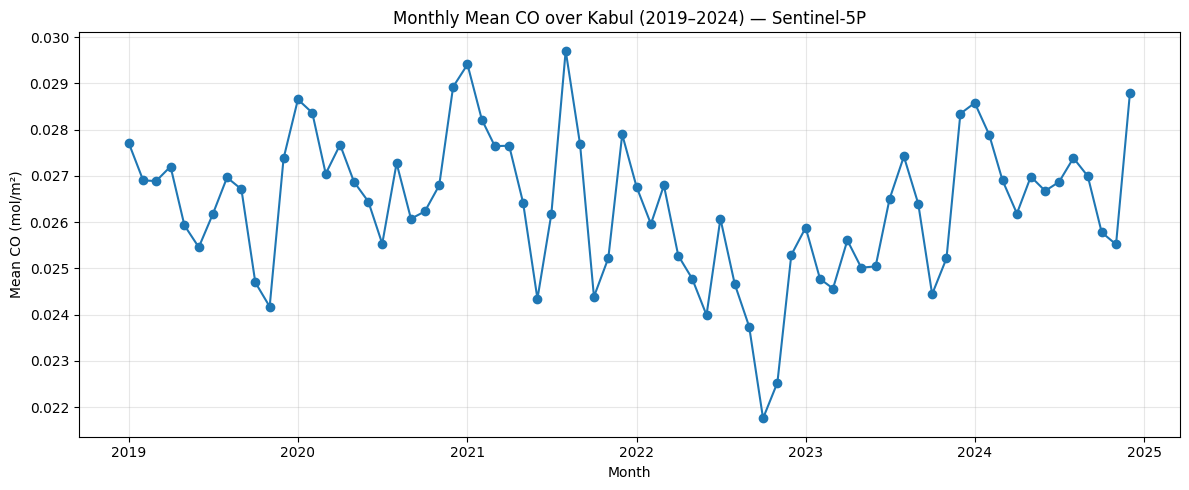

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df_kabul_co["month_start"], df_kabul_co["co"], marker="o")
plt.title("Monthly Mean CO over Kabul (2019–2024) — Sentinel-5P")
plt.xlabel("Month")
plt.ylabel("Mean CO (mol/m²)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
city_dfs_co = []

for city_name, info in CITIES.items():
    print(f"Processing {city_name}...")
    df_city = get_monthly_co_for_city(
        city_name=city_name,
        geom=info["geom"],
        start_date=start,
        end_date=end
    )
    city_dfs_co.append(df_city)

df_all_co = pd.concat(city_dfs_co, ignore_index=True)
df_all_co = df_all_co.sort_values(["city", "month_start"])
df_all_co.head()

Processing Kabul...
Processing Herat...
Processing Mazar...
Processing Kandahar...
Processing Jalalabad...


,city,month_start,co
72,Herat,2019-01-01,0.028474
73,Herat,2019-02-01,0.028860
74,Herat,2019-03-01,0.029044
75,Herat,2019-04-01,0.030099
76,Herat,2019-05-01,0.029318


In [8]:
pivot_co = df_all_co.pivot(index="month_start", columns="city", values="co")
pivot_co

city,Herat,Jalalabad,Kabul,Kandahar,Mazar
month_start,,,,,
2019-01-01,0.028474,0.032651,0.027708,0.028316,0.031697
2019-02-01,0.028860,0.032102,0.026902,0.028205,0.032476
2019-03-01,0.029044,0.032015,0.026891,0.028921,0.032187
2019-04-01,0.030099,0.031693,0.027204,0.029719,0.031645
2019-05-01,0.029318,0.030607,0.025931,0.029148,0.031279
...,...,...,...,...,...
2024-08-01,0.029457,0.033610,0.027388,0.029721,0.032185
2024-09-01,0.028930,0.034081,0.026995,0.029136,0.032126
2024-10-01,0.027883,0.032610,0.025780,0.028602,0.030281


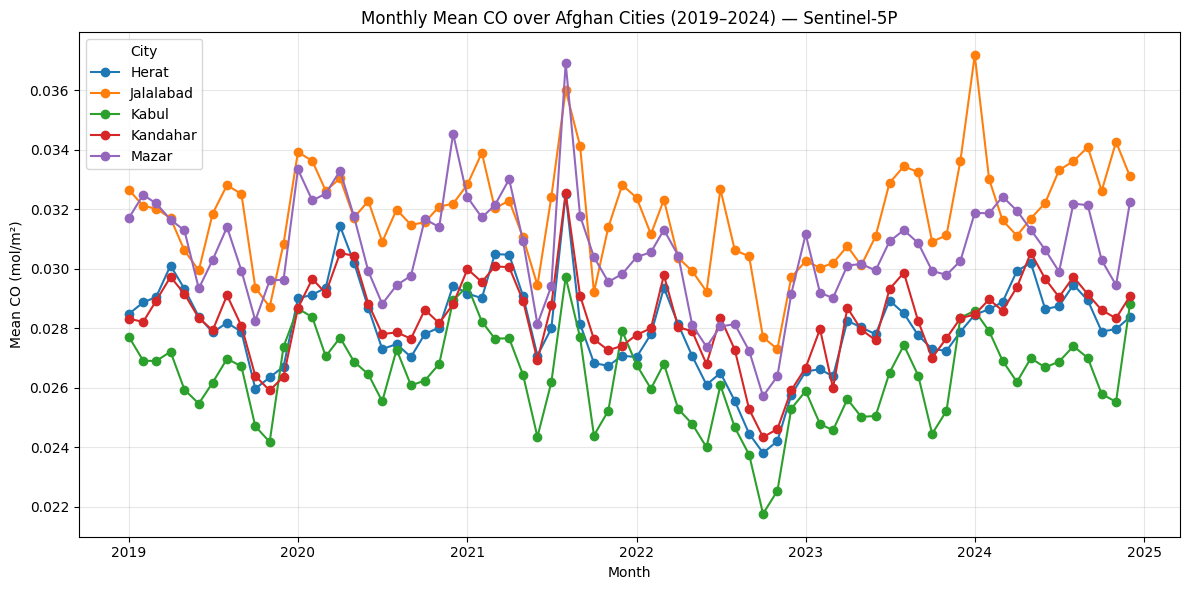

In [9]:
plt.figure(figsize=(12, 6))

for city in pivot_co.columns:
    plt.plot(pivot_co.index, pivot_co[city], marker="o", label=city)

plt.title("Monthly Mean CO over Afghan Cities (2019–2024) — Sentinel-5P")
plt.xlabel("Month")
plt.ylabel("Mean CO (mol/m²)")
plt.grid(True, alpha=0.3)
plt.legend(title="City")
plt.tight_layout()
plt.show()

### Interpretation

This chart compares monthly mean CO column densities over five Afghan cities from 2019–2024, using Sentinel-5P OFFL/L3 CO data.

CO is a combustion tracer, often linked to vehicle emissions, generators, trash burning, and residential heating/cooking. Seasonal peaks in CO typically align with colder months and periods of higher fuel use, while lower values are seen in warmer months. Comparing CO and NO₂ patterns across cities helps distinguish differences in combustion intensity, fuel use, and local emission sources.